In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import Flowers102


In [16]:
dataset_train = Flowers102(root='data/', split="train", download=True)
dataset_val = Flowers102(root='data/', split="val", download=True)
dataset_test = Flowers102(root='data/', split="test", download=True)

print("Train:", len(dataset_train))
print("Val:", len(dataset_val))
print("Test:", len(dataset_test))

Train: 1020
Val: 1020
Test: 6149


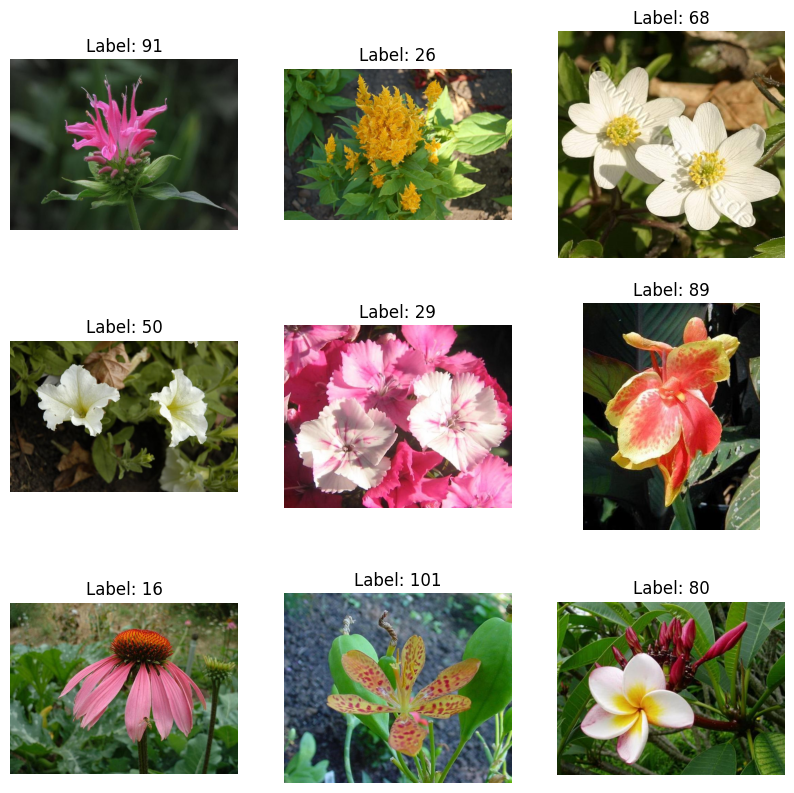

In [17]:
import random
import scipy.io

from matplotlib import pyplot as plt

imagelabels = scipy.io.loadmat("data/flowers-102/imagelabels.mat")

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, (images, targets) in enumerate(random.sample(list(dataset_train), 9)):
    ax = axs[i // 3, i % 3]
    ax.imshow(images)
    ax.set_title(f"Label: {targets}")
    ax.axis('off')
plt.show()


In [18]:
# model = torchvision.models.swin_t(weights='DEFAULT')


In [19]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.BatchNorm2d(8),  
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(238144, 4096),
            nn.BatchNorm1d(4096), 
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.BatchNorm1d(1000), 
            nn.ReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [20]:
img_size = 128
batch_size = 64

lr = 0.001
epochs = 100

val_freq = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# device = torch.device('cpu')

Using device: cuda


In [21]:
model = CNN()
model = model.to(device)

In [22]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
])
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack([transform(image) for image in images])
    targets = torch.tensor(targets)
    return images, targets

In [23]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [25]:
# TRAIN
from tqdm import tqdm

metrics = {
    "train": {
        "acc": [], 
        "loss": [],
    },
    "val": {        
        "acc": [],
        "loss": [],
    }
}

for epoch in range(epochs):
    model.train()
    with tqdm(dataloader_train, unit="batch", total=len(dataloader_train), desc=f"[TRAIN] Epoch {epoch}/{epochs}") as trainbar:
        for i, (images, targets) in enumerate(trainbar):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)

            predicted = torch.argmax(outputs, 1)
            correct = (predicted == targets).sum().item()

            metrics["train"]["acc"].append(correct / batch_size)
            metrics["train"]["loss"].append(loss.item())

            loss.backward()
            optimizer.step()

            trainbar.set_postfix(loss=loss.item())

    if (epoch+1) % val_freq == 0:
        # VALIDATION
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            with tqdm(dataloader_val, unit="batch", total=len(dataloader_val), desc=f"[VAL] Epoch {epoch}/{epochs}") as valbar:
                for images, targets in valbar:
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, targets)

                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

                    metrics["val"]["acc"].append(correct / total)
                    metrics["val"]["loss"].append(loss.item())

                    valbar.set_postfix(acc=correct / total)



[TRAIN] Epoch 0/100:   0%|          | 0/16 [00:00<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x53824 and 238144x4096)

In [ ]:
import os


save_path = "output/"
os.makedirs(save_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_path, f"ckpt_{epochs}_{device}.pt"))

In [ ]:
# TEST
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model.eval()

metrics = {
    "correct": 0,
    "total": 0,
}
with torch.no_grad():
    with tqdm(dataloader_test, unit="batch", total=len(dataloader_test), desc=f"[TEST]") as testbar:
        for images, targets in testbar:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            metrics["total"] += targets.size(0)
            metrics["correct"] += (predicted == targets).sum().item()

            testbar.set_postfix(acc=metrics["correct"] / metrics["total"])

print(f"Test accuracy: {metrics['correct'] / metrics['total']:.2f}")


[TEST]: 100%|██████████| 193/193 [01:00<00:00,  3.19batch/s, acc=0.289]

Test accuracy: 0.29


KeyError: 'train'

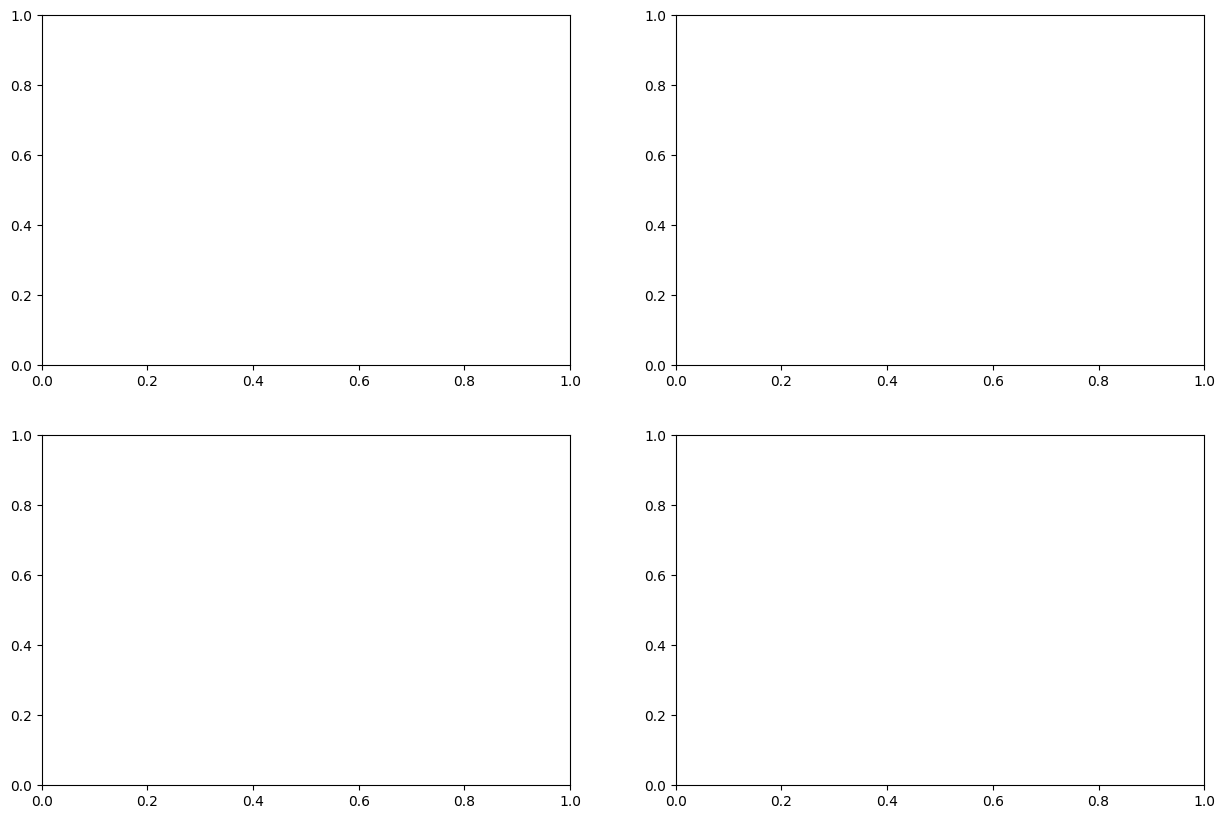

In [ ]:
# PLOT

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(metrics["train"]["acc"], label="train")
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(metrics["train"]["loss"], label="train")
axs[0, 1].set_title("Loss")
axs[0, 1].legend()

axs[1, 0].plot(metrics["val"]["acc"], label="val")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(metrics["val"]["loss"], label="val")
axs[1, 1].set_title("Loss")
axs[1, 1].legend()

plt.show()


In [ ]:
import copy


resnet18_frozen = torchvision.models.resnet18(weights="DEFAULT")
resnet18_finetune = copy.deepcopy(resnet18_frozen)

# Fixed feature extractor
for name, param in resnet18_frozen.named_parameters()[:-1]:
    param.requires_grad = False

resnet18_frozen